<header class="page-header">
    <center>
    <h1>A quick Tour of Scikit Learn</h1>
    <h2>Vancouver Open Source Software Event hosted by the Microsoft Garage</h2>
    <h3>Authors: Andreas Putz, MistyWest</h3>
    </center>
</header>

# Setup

In [91]:
## Widescreen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [108]:
# Base Packages
import os
import re
import time
import warnings
from itertools import cycle, islice
import pickle

# Basic data stack
import scipy as sp
import numpy as np
import pandas as pd

# Plotting
%matplotlib notebook
from ipywidgets import *
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

import seaborn as sns

import cv2

import pydotplus

import sklearn as skl
from sklearn import datasets
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import covariance
from sklearn import tree


# Data Preprocessing with Sklearn

## Data Normalization

**Problem**: Qunatitative data is typically the measurement of something: temperature values, monthly sales, RGB image data. On 64 bit architectures it is sometimes advantageous to represent this data as floating point numbers and to normalize their values (typically from 0 to 1 or from -1 to 1).

Rescaling is a common task for machine larning. It avoids retraining if the absolute scale of the datasets varies due to experimental equipment or other reaseons (e.g.8bit vs 16bit RGB images)

### Approach 1: MinMax scaling

In [25]:
feature = sp.expand_dims(100*sp.rand(10000),1) # Random draw from a uniform distribution
#feature = sp.expand_dims(100*sp.randn(10000),1) # Random draw from a uniform distribution

In [26]:
feature

array([[84.00240187],
       [39.06499697],
       [80.7243466 ],
       ...,
       [91.87886399],
       [15.08691259],
       [81.77331089]])

<IPython.core.display.Javascript object>


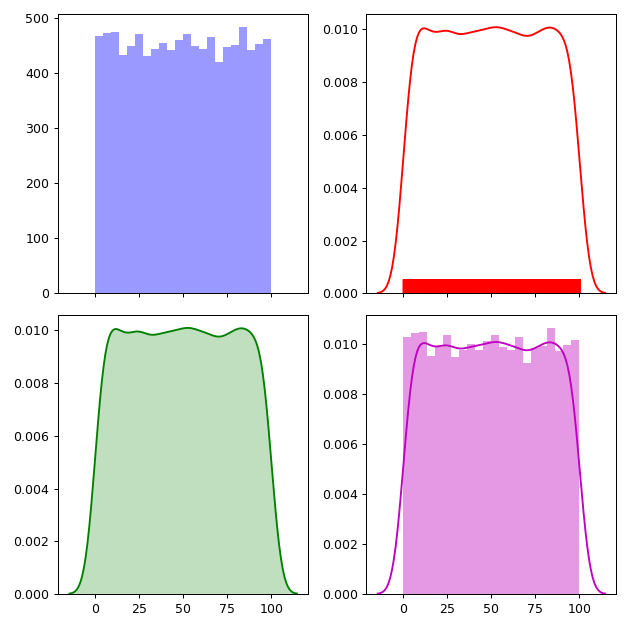

In [29]:
def plot_histogram(data=sp.rand(100)):
    '''Plot a simple histogram with binsize determined automatically
    
    Args:
      data: numpy array or pandas dataframe containing the data
    '''
    f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)

    sns.distplot(data, kde=False, color="b", ax=axes[0, 0])
    # Plot a kernel density estimate and rug plot
    sns.distplot(data, hist=False, rug=True, color="r", ax=axes[0, 1])
    # Plot a filled kernel density estimate
    sns.distplot(data, hist=False, color="g", kde_kws={"shade": True}, ax=axes[1, 0])
    # Plot a historgram and kernel density estimate
    sns.distplot(data, color="m", ax=axes[1, 1])

    plt.tight_layout()
    
plot_histogram(data=feature)

<IPython.core.display.Javascript object>


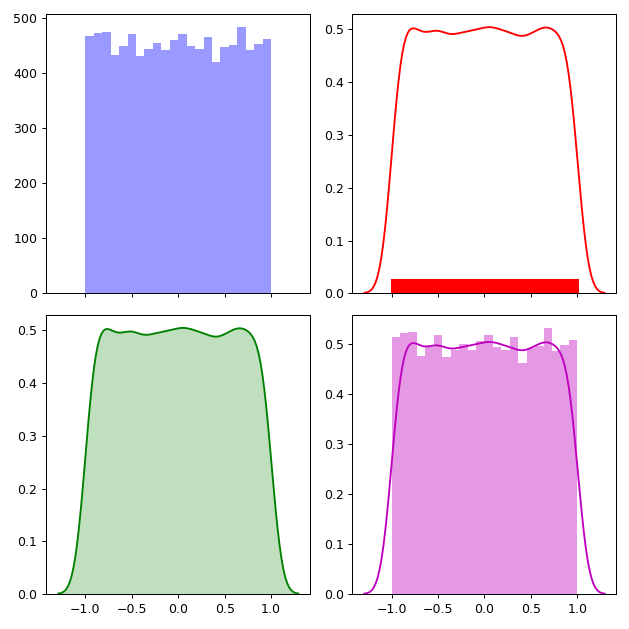

In [30]:
# Create a scaler:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(-1,1))
#Scale Feature:
scaled_feature = minmax_scale.fit_transform(feature)
plot_histogram(data=scaled_feature)

### Approach 2: Transform to mean of 0 and standard deviation of 1

<IPython.core.display.Javascript object>


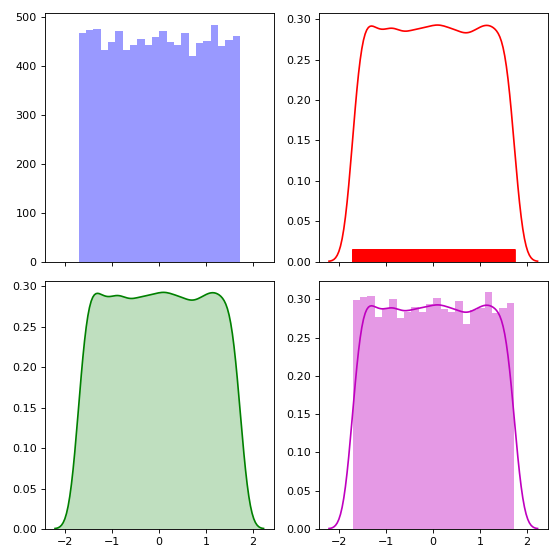

In [32]:
# Create a scaler:
standard_scale = preprocessing.StandardScaler()
#Scale Feature:
scaled_feature = standard_scale.fit_transform(feature)
plot_histogram(data=scaled_feature)

In [34]:
print(f"The original data had a mean of {sp.mean(feature)} and standard deviation of {sp.std(feature)}")
print(f"The scaled data had a mean of {sp.mean(scaled_feature)} and standard deviation of {sp.std(scaled_feature)}")

The original data had a mean of 49.89024815397196 and standard deviation of 29.011549176621706
The scaled data had a mean of 1.3162804179955856e-16 and standard deviation of 1.0


## Outlier Detection

**Problem**: Identify extreme observations.

Detecting outliers sadly is more an art, as in most cases there is no clear definition of what criteria exactly define a measurement as an outlier.

A common method is to assume that the data is normally distributed.

<IPython.core.display.Javascript object>


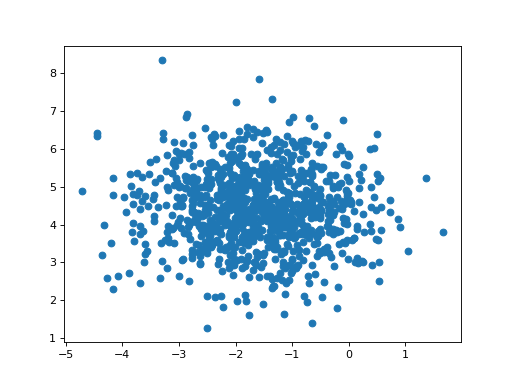

In [41]:
# Create Simulated Data
features, _ = datasets.make_blobs(n_samples=1000,n_features=2,centers=1,random_state=1)
plt.figure()
plt.plot(features[:,0],features[:,1],'o')

<IPython.core.display.Javascript object>


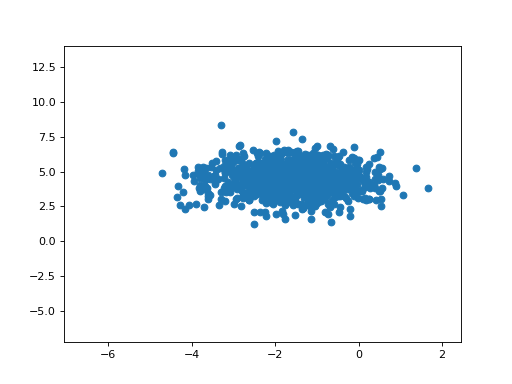

In [44]:
# Add outliers:
features[0,0] = 10000
features[0,1] = 10000

plt.figure()
plt.plot(features[:,0],features[:,1],'o')

In [52]:
args = sp.argwhere(outlier_class==-1)[:,0]


array([  0,   2,  10,  16,  24,  44,  69,  89,  98,  99, 104, 105, 123,
       129, 132, 154, 163, 164, 178, 181, 193, 221, 236, 247, 261, 265,
       273, 274, 281, 293, 303, 326, 329, 354, 360, 378, 387, 392, 395,
       398, 410, 414, 415, 438, 440, 450, 456, 471, 492, 493, 494, 516,
       533, 535, 550, 563, 581, 590, 602, 656, 665, 680, 686, 691, 692,
       707, 708, 713, 719, 726, 735, 738, 740, 765, 767, 778, 788, 797,
       799, 803, 809, 812, 813, 848, 859, 861, 865, 876, 877, 899, 904,
       908, 911, 929, 932, 936, 954, 956, 958, 962])

<IPython.core.display.Javascript object>


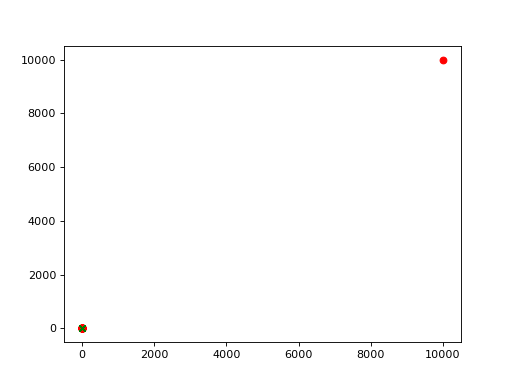

In [56]:
# Create Outlier Detector
outlier_detector = covariance.EllipticEnvelope(contamination=0.1)
#Fit (Train)
outlier_detector.fit(features)
# Predict (Infer)
outlier_class= outlier_detector.predict(features)

plt.figure()
args = sp.argwhere(outlier_class==-1)[:,0]
plt.plot(features[args,0],features[args,1],'ro')

args = sp.argwhere(outlier_class==1)[:,0]
plt.plot(features[args,0],features[args,1],'gx')

**Major Problem**: Hyperparameter *contamination* has to be specified!!!

## Dataset Augmentation:

In [95]:
training_file =  "../data/raw/train.p"
validation_file = "../data/raw/valid.p"
testing_file =   "../data/raw/test.p"

# In this case the data is already split. If not use sklearn.model_selection.train_test_split¶
#

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [97]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)

image_shape = X_test[0,...].shape
n_classes = len(sp.unique(y_train))
df_names = pd.read_csv('../data/raw/signnames.csv')

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [98]:
df_names

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


<IPython.core.display.Javascript object>


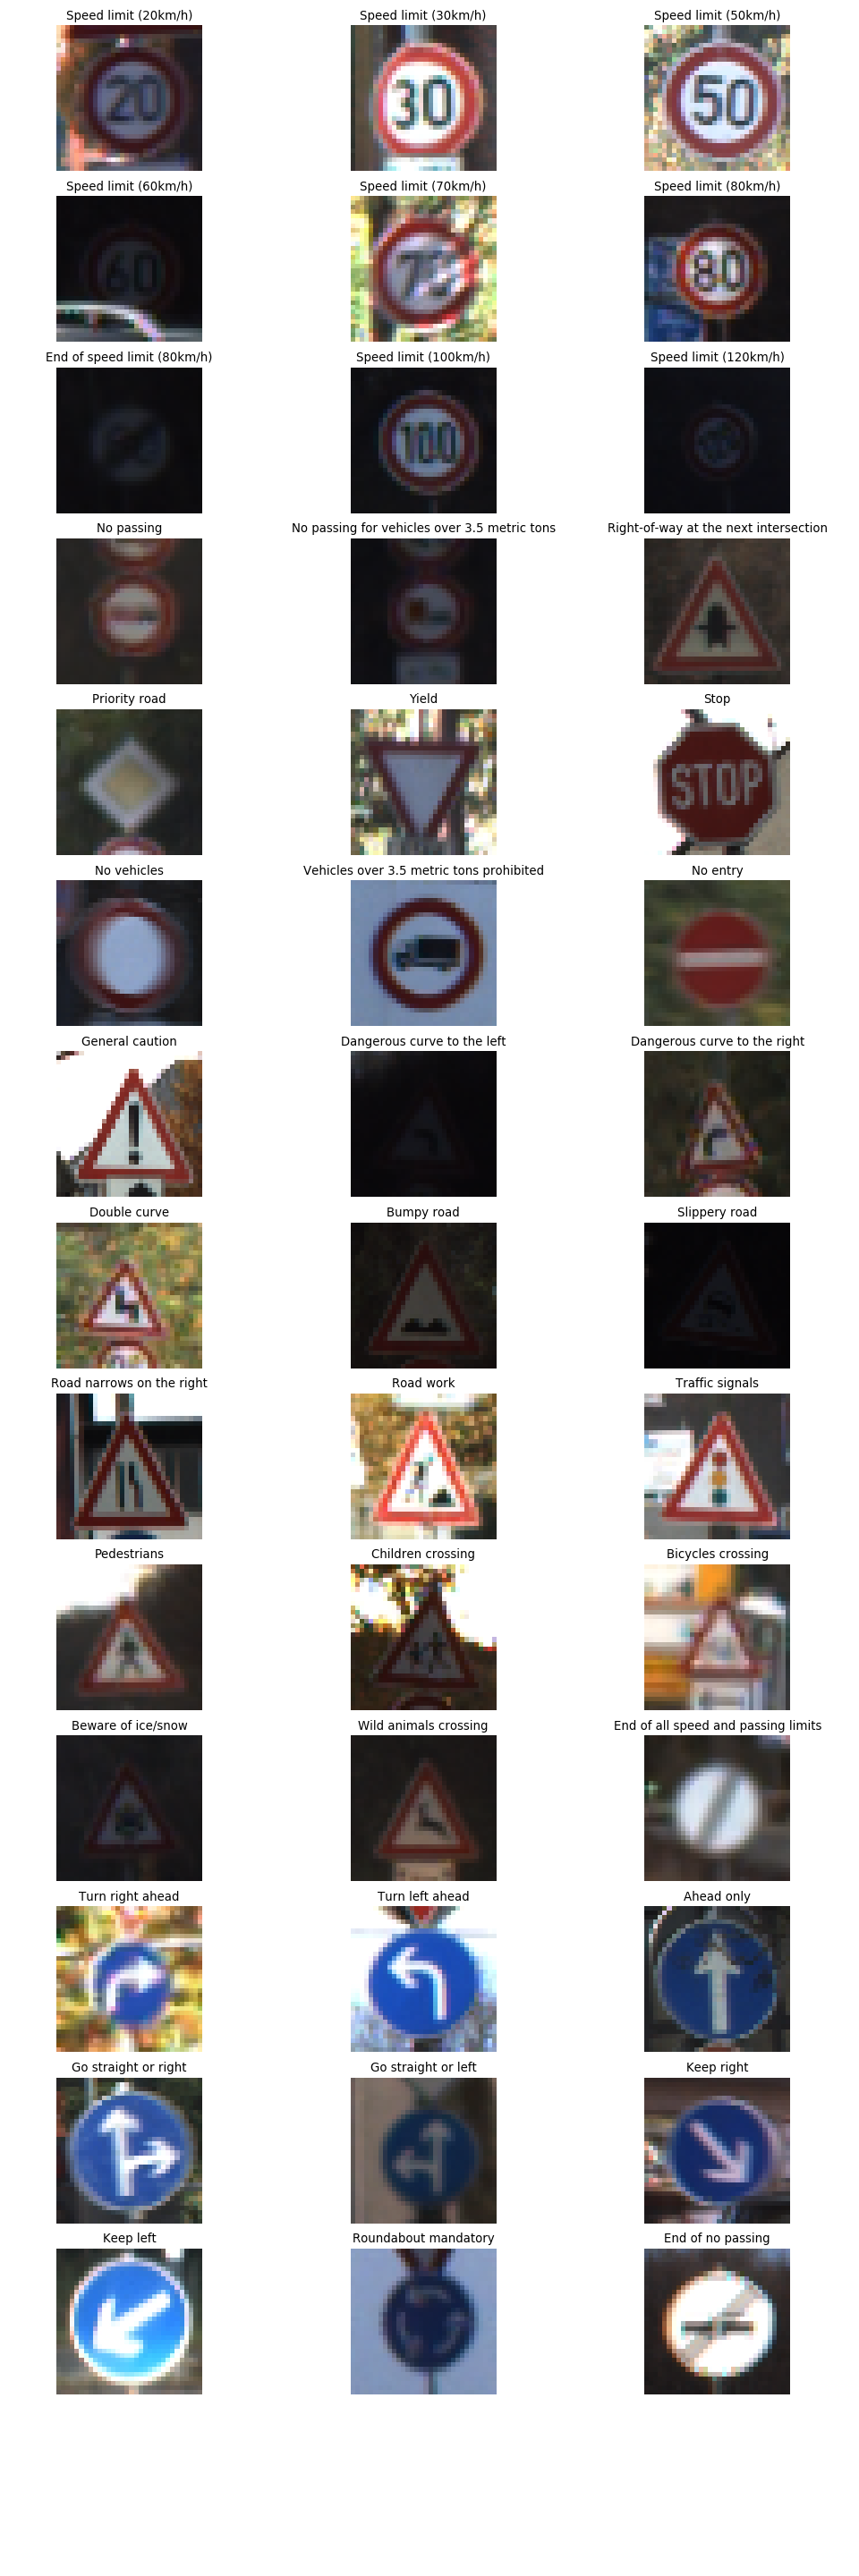

In [101]:
plt.figure(figsize=(12,36))
for i in range(1,43):
    plt.subplot(15,3,i)
    plt.imshow(X_test[y_test==i-1][0,...])
    plt.title(df_names.loc[i-1]['SignName'])
    plt.axis('off')
    
plt.tight_layout()


<IPython.core.display.Javascript object>


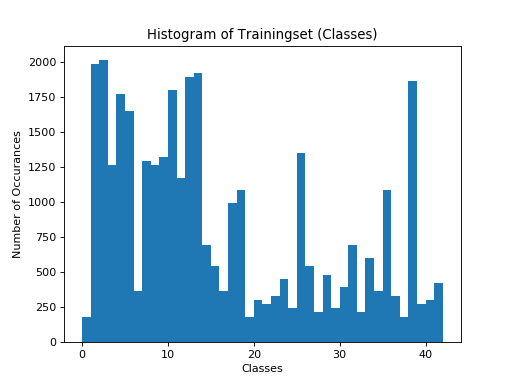

Text(0.5, 1.0, 'Histogram of Trainingset (Classes)')

In [102]:
plt.figure()
plt.hist(y_train,bins = 42)

plt.xlabel('Classes')
plt.ylabel('Number of Occurances')
plt.title("Histogram of Trainingset (Classes)")

### Data Augmentation

In [112]:
def create_affine_transform_augmentation(img, random_limits=(0.8, 1.1),noise=False, bright=True):
        '''
        Creates an augmentation by computing a homography from three
        points in the image to three randomly generated points
        '''
        
        #if noise:
        #    img = skimage.util.random_noise(img)
        
        if bright:
            shifted = img + 255   # shift to (0,2) range
            img_max_value = max(shifted.flatten())
            #max_coef = min(255./img_max_value,1)
            max_coef = 255./img_max_value
            min_coef = max_coef - 0.6
            coef = sp.random.uniform(min_coef, max_coef)
            img = shifted * coef - 255
            
            #print(f'{img_max_value},{min_coef},{max_coef}')
        
        
        y, x = img.shape[:2]
        fx = float(x)
        fy = float(y)
        src_point = sp.float32([[fx/2, fy/3,],
                                [2*fx/3, 2*fy/3],
                                [fx/3, 2*fy/3]])
        random_shift = (sp.random.rand(3,2) - 0.5) * 2 * (random_limits[1]-random_limits[0])/2 + sp.mean(random_limits)
        dst_point = src_point * random_shift.astype(sp.float32)
        transform = cv2.getAffineTransform(src_point, dst_point)
        borderValue = 0
        if img.ndim == 3:
            borderValue = sp.median(sp.reshape(img, (img.shape[0]*img.shape[1],-1)), axis=0)
        else:
            borderValue=sp.median(img)
        warped_img = cv2.warpAffine(img, transform, dsize=(x,y), borderValue=borderValue)
        
        #tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,translation=(210, 50))
        #tform = skimage.transform.AffineTransform(translation=(sp.random.randint(-3,3), sp.random.randint(-3,3)))
        #warped_img = skimage.transform.warp(warped_img, tform.inverse)
        
        return warped_img.astype(sp.uint8)

<IPython.core.display.Javascript object>


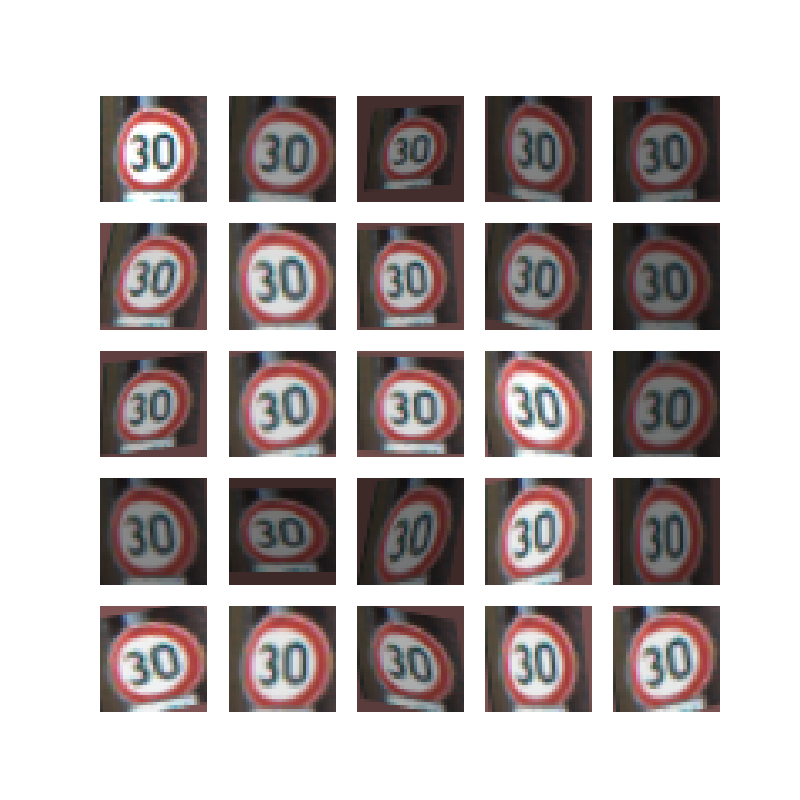

In [113]:
plt.figure(figsize=(10,10))
plt.subplot(5,5,1)
plt.imshow(X_test[1,...])
plt.axis('off')


for i in range(2,26):
    plt.subplot(5,5,i)
    plt.imshow(create_affine_transform_augmentation(X_test[1,...],random_limits=(0.90,1.1)))
    plt.axis('off')

In [115]:
UGMENT = True
AUGMENT_THRESH = 700
if AUGMENT:
    print('X, y shapes:', X_train.shape, y_train.shape)

    input_indices = []
    output_indices = []

    for class_n in range(n_classes):
        print(f'{class_n} : ', end='')
        class_indices = sp.where(y_train == class_n)
        n_samples = len(class_indices[0])
        if n_samples < AUGMENT_THRESH:
            for i in range(AUGMENT_THRESH - n_samples):
                input_indices.append(class_indices[0][i%n_samples])
                output_indices.append(X_train.shape[0])
                new_img = X_train[class_indices[0][i % n_samples]]
                new_img = create_affine_transform_augmentation(new_img,random_limits=(0.9,1.1), noise=True)
                X_train = sp.concatenate((X_train, [new_img]), axis=0)
                y_train = sp.concatenate((y_train, [class_n]), axis=0)
                if i % 100 == 0:
                    print('|', end='')
                elif i % 20 == 0:
                    print('-',end='')
        print('')

    print('X, y shapes:', X_train.shape, y_train.shape)

X, y shapes: (34799, 32, 32, 3) (34799,)
0 : |----|----|----|----|----|
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|-
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |
15 : |----|--
16 : |----|----|----|-
17 : 
18 : 
19 : |----|----|----|----|----|
20 : |----|----|----|----
21 : |----|----|----|----|-
22 : |----|----|----|---
23 : |----|----|--
24 : |----|----|----|----|--
25 : 
26 : |----|--
27 : |----|----|----|----|----
28 : |----|----|
29 : |----|----|----|----|--
30 : |----|----|----|
31 : |
32 : |----|----|----|----|----
33 : |----|
34 : |----|----|----|-
35 : 
36 : |----|----|----|---
37 : |----|----|----|----|----|
38 : 
39 : |----|----|----|----|-
40 : |----|----|----|----
41 : |----|----|----|----|----
42 : |----|----|----|----|----
X, y shapes: (43880, 32, 32, 3) (43880,)


<IPython.core.display.Javascript object>


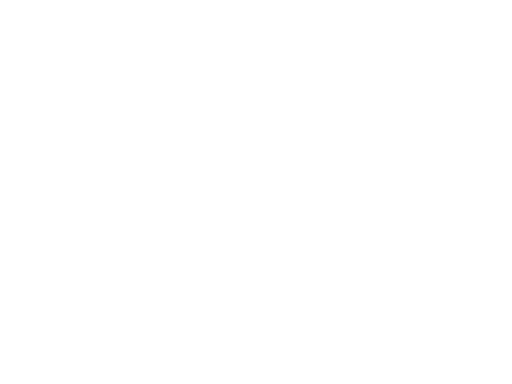

<IPython.core.display.Javascript object>


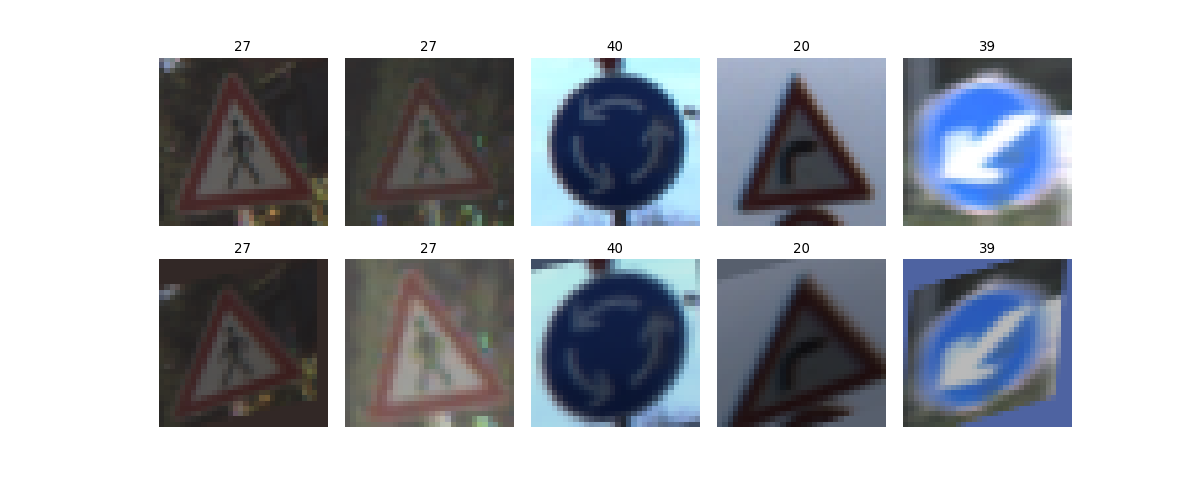

In [116]:
if AUGMENT:
    # show comparisons of 5 random augmented data points
    plt.figure()
    choices = list(range(len(input_indices)))
    picks = []
    for i in range(5):
        rnd_index = sp.random.randint(low=0,high=len(choices))
        picks.append(choices.pop(rnd_index))
    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    for i in range(5):
        axs[i].axis('off')
        axs[i].imshow(X_train[input_indices[picks[i]]].astype(sp.uint8))
        axs[i].set_title(y_train[input_indices[picks[i]]])
    for i in range(5):
        axs[i+5].axis('off')
        axs[i+5].imshow(X_train[output_indices[picks[i]]])
        axs[i+5].set_title(y_train[output_indices[picks[i]]])

<IPython.core.display.Javascript object>


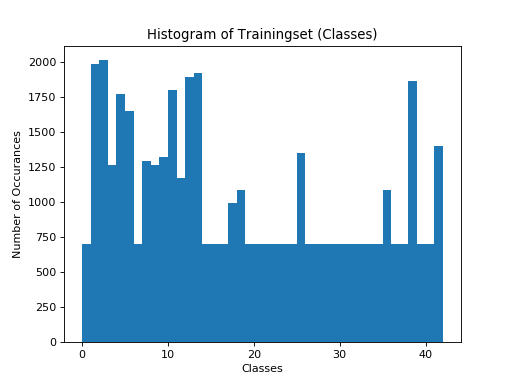

Text(0.5, 1.0, 'Histogram of Trainingset (Classes)')

In [117]:
plt.figure()
plt.hist(y_train,bins = 42)

plt.xlabel('Classes')
plt.ylabel('Number of Occurances')
plt.title("Histogram of Trainingset (Classes)")

From here, we can do a few more image processing operations and then go to Tensorflow of Pythorch

# A small Decision Tree Example

Decisio tree based models are based on a series of rule ("if Temperature is higher than 10 degC") are chained together. Decision trees are interpratable as they can be completely drawn out. We will see that in a few moments.

The iris dataset contains three different type of irises (Setosa, Veriscolour and Virginica). Their petal and sepal length are stored in a 150x4 ndarray.

In [68]:
from IPython.display import IFrame

IFrame(src='https://en.wikipedia.org/wiki/Iris_flower_data_set', width=1200,height=600)

In [61]:
iris = datasets.load_iris()
features = iris.data
target   = iris.target

In [73]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [60]:
features.shape

(150, 4)

In [69]:
# Create the Decision tree classifier
decisiontree = tree.DecisionTreeClassifier(random_state=0)

# Train Model:
model = decisiontree.fit(features, target)

In [70]:
# Add ovser
observation = [[5,4,3,2]]
print(f"Observation: {observation}, Prediction: {model.predict(observation)} with propability {model.predict_proba(observation)}")

Observation: [[5, 4, 3, 2]], Prediction: [1] with propability [[0. 1. 0.]]


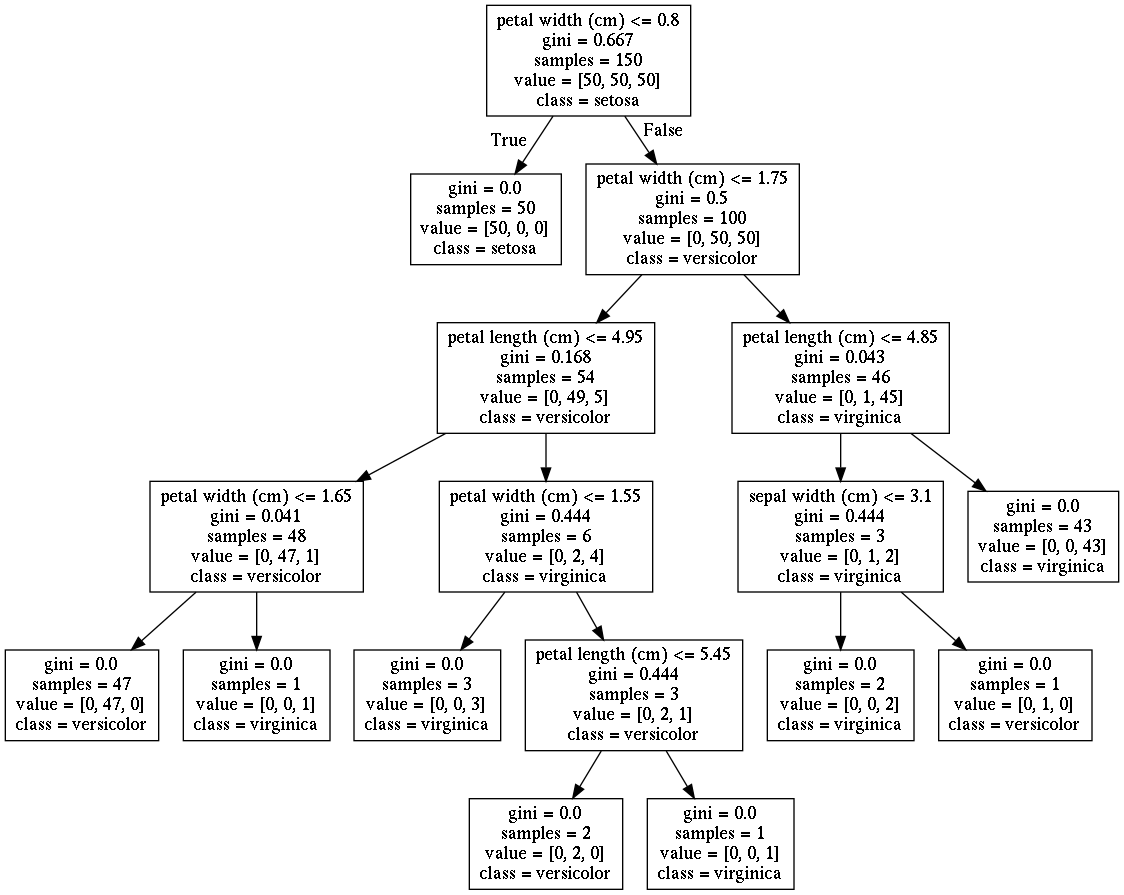

In [75]:
from IPython.display import Image
dot_data = tree.export_graphviz(decisiontree,out_file=None, feature_names=iris.feature_names, class_names=iris.target_names)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# A little algorithm overview for clustering

## Generate Datasets

In [77]:
n_samples = 1500

noisy_circles is of type <class 'tuple'>


<IPython.core.display.Javascript object>


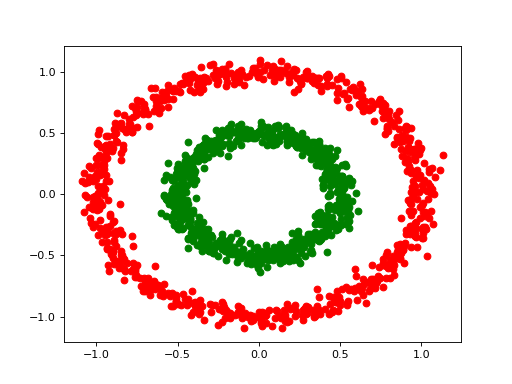

In [78]:
noisy_circles = skl.datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

print(f"noisy_circles is of type {type(noisy_circles)}")

plt.figure()

args = sp.argwhere(noisy_circles[1]==0)[:,0]
circle_1 = noisy_circles[0][args,:]
plt.plot(circle_1[:,0],circle_1[:,1],'ro')

args = sp.argwhere(noisy_circles[1]==1)[:,0]
circle_2 = noisy_circles[0][args,:]
plt.plot(circle_2[:,0],circle_2[:,1],'go')



noisy_moons is of type <class 'tuple'>


<IPython.core.display.Javascript object>


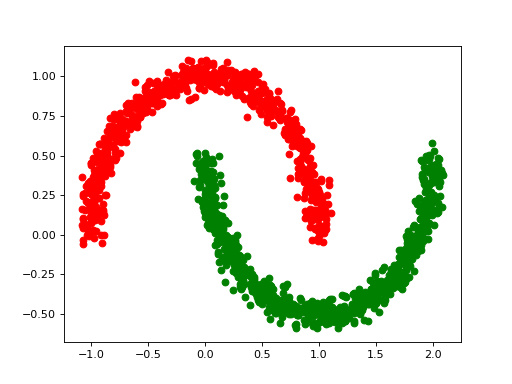

In [84]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

print(f"noisy_moons is of type {type(noisy_circles)}")

plt.figure()

args = sp.argwhere(noisy_moons[1]==0)[:,0]
circle_1 = noisy_moons[0][args,:]
plt.plot(circle_1[:,0],circle_1[:,1],'ro')

args = sp.argwhere(noisy_moons[1]==1)[:,0]
circle_2 = noisy_moons[0][args,:]
plt.plot(circle_2[:,0],circle_2[:,1],'go')



In [86]:
no_structure = sp.random.rand(n_samples, 2), None

In [87]:
# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

In [88]:
# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

<IPython.core.display.Javascript object>


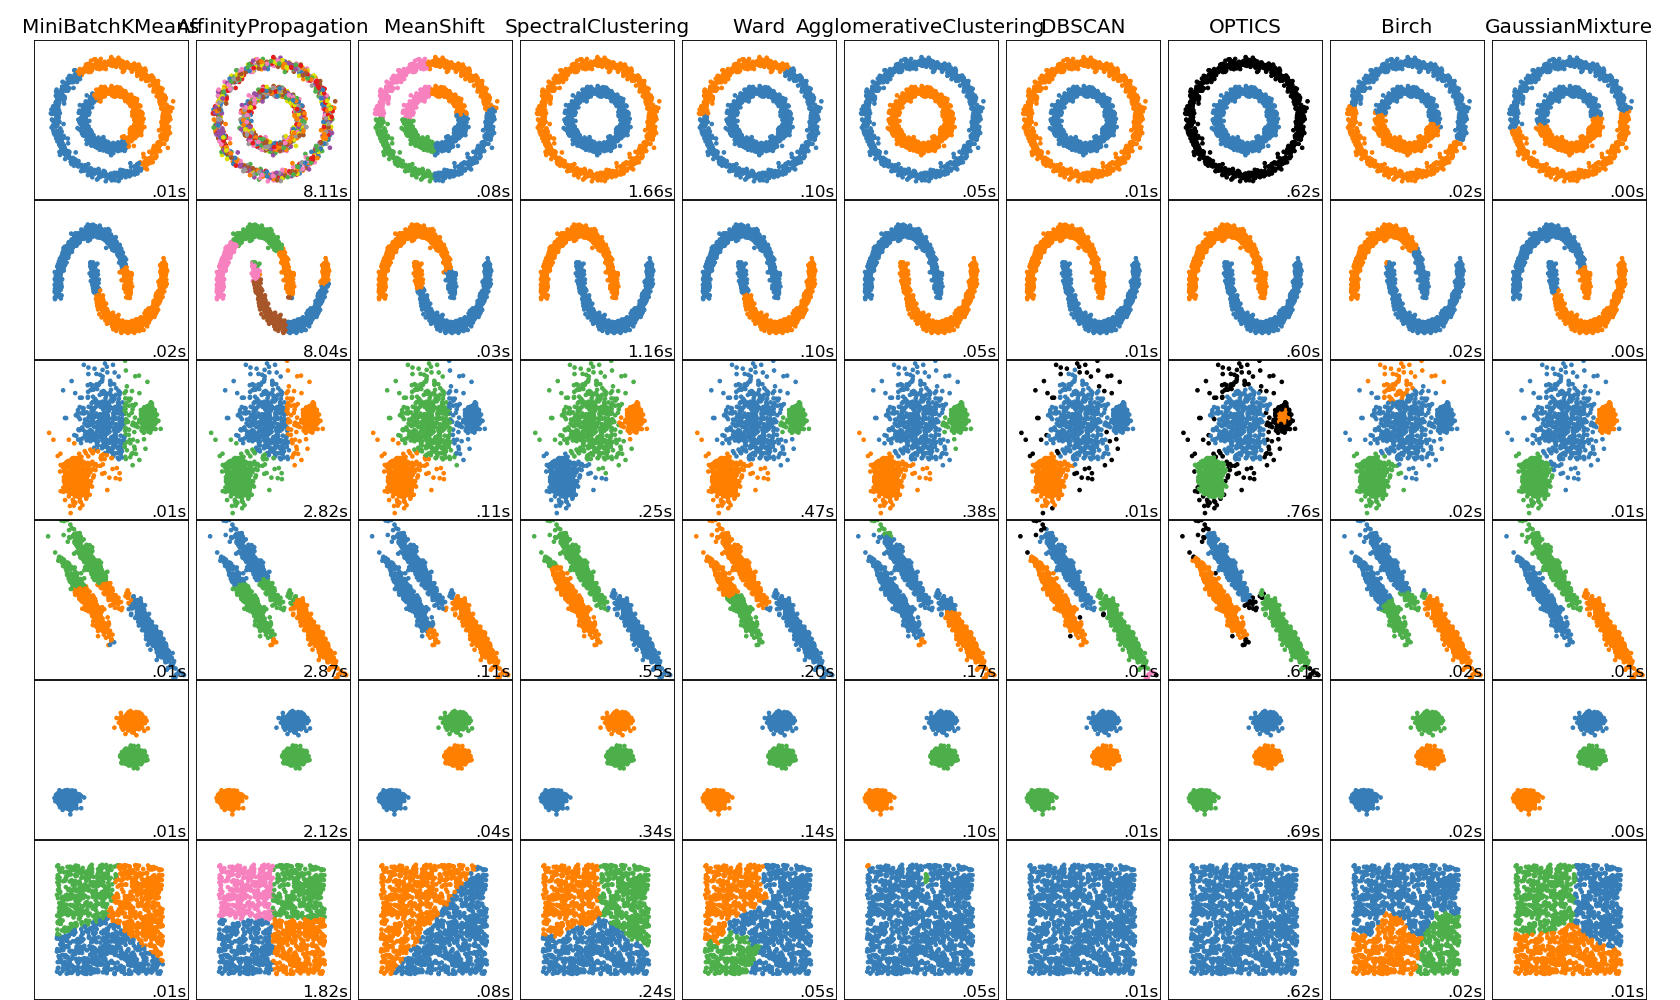

In [89]:
# ============
# Try a few clustering algorithms
# (Slightly adapted from the scilit learn website: )
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1